In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import time
import requests

In [3]:
# Parameters
tickers = ['AAPL', 'MSFT', 'GOOGL']
sequence_length = 30
batch_size = 64
hidden_size = 50
num_epochs = 10
learning_rate = 0.001

# Download stock data
def get_stock_data(ticker):
    df = yf.download(ticker, start="2015-01-01", end="2023-12-31")
    return df[['Close']]

data = pd.concat([get_stock_data(t) for t in tickers], axis=1)
data.columns = tickers
data.dropna(inplace=True)

# Normalize
scalers = {}
scaled_data = pd.DataFrame()
for ticker in tickers:
    scaler = MinMaxScaler()
    scaled_data[ticker] = scaler.fit_transform(data[[ticker]]).flatten()
    scalers[ticker] = scaler

# Dataset
class StockDataset(Dataset):
    def __init__(self, series, seq_len):
        self.X = []
        self.y = []
        for i in range(len(series) - seq_len):
            self.X.append(series[i:i+seq_len])
            self.y.append(series[i+seq_len])
        self.X = np.array(self.X)
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Use one ticker for demonstration (e.g., AAPL)
dataset = StockDataset(scaled_data['AAPL'].values, sequence_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x.unsqueeze(-1))
        return self.fc(out[:, -1, :])

model = LSTM(input_size=1, hidden_size=hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train
for epoch in range(num_epochs):
    for X_batch, y_batch in dataloader:
        output = model(X_batch)
        loss = criterion(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/10, Loss: 0.0306
Epoch 2/10, Loss: 0.0022
Epoch 3/10, Loss: 0.0007
Epoch 4/10, Loss: 0.0004
Epoch 5/10, Loss: 0.0006
Epoch 6/10, Loss: 0.0004
Epoch 7/10, Loss: 0.0005
Epoch 8/10, Loss: 0.0004
Epoch 9/10, Loss: 0.0004
Epoch 10/10, Loss: 0.0005


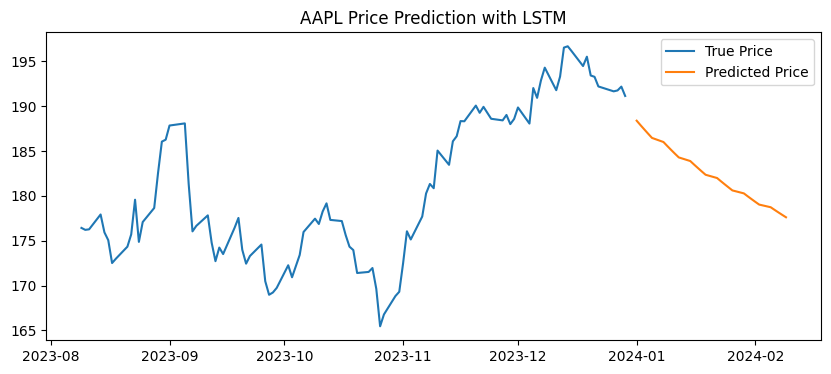

In [10]:
# Evaluate on last part of dataset
model.eval()
test_inputs = scaled_data['AAPL'].values[-sequence_length:].tolist()
predictions = []

for _ in range(30):  # predict next 30 days
    seq = torch.tensor(test_inputs[-sequence_length:], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        pred = model(seq).item()
        predictions.append(pred)
        test_inputs.append(pred)

# Inverse transform
predicted_prices = scalers['AAPL'].inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot
plt.figure(figsize=(10, 4))
plt.plot(data.index[-100:], data['AAPL'].values[-100:], label='True Price')
future_index = pd.date_range(start=data.index[-1], periods=31, freq='B')[1:]
plt.plot(future_index, predicted_prices, label='Predicted Price')
plt.legend()
plt.title('AAPL Price Prediction with LSTM')
plt.show()